# Predictive Maintenance for Hydraulic Systems

Attribute Information:
The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:
Sensor Physical quantity Unit Sampling rate

### Training Data

`PS1.txt` to `SE.txt` files

- PS1 Pressure bar 100 Hz
- PS2 Pressure bar 100 Hz
- PS3 Pressure bar 100 Hz
- PS4 Pressure bar 100 Hz
- PS5 Pressure bar 100 Hz
- PS6 Pressure bar 100 Hz
- EPS1 Motor power W 100 Hz
- FS1 Volume flow l/min 10 Hz
- FS2 Volume flow l/min 10 Hz
- TS1 Temperature Â°C 1 Hz
- TS2 Temperature Â°C 1 Hz
- TS3 Temperature Â°C 1 Hz
- TS4 Temperature Â°C 1 Hz
- VS1 Vibration mm/s 1 Hz
- CE Cooling efficiency (virtual) % 1 Hz
- CP Cooling power (virtual) kW 1 Hz
- SE Efficiency factor % 1 Hz

### Training Labels

`profile.txt` file

- column 0: Cooler condition / %:
    - 3: close to total failure
    - 20: reduced effifiency
    - 100: full efficiency

- column 1: Valve condition / %:
    - 100: optimal switching behavior
    - 90: small lag
    - 80: severe lag
    - 73: close to total failure

- column 2: Internal pump leakage:
    - 0: no leakage
    - 1: weak leakage
    - 2: severe leakage

- column 3: Hydraulic accumulator / bar:
    - 130: optimal pressure
    - 115: slightly reduced pressure
    - 100: severely reduced pressure
    - 90: close to total failure

- column 4: stable flag:
    - 0: conditions were stable
    - 1: static conditions might not have been reached yet
    
Import the libraries we will need

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datatable as dt
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import xgboost as xgb
import os

Import Data Files

In [2]:
dir_path = '/Users/jmedel/Development/James/Hydraulic-System-Predictive-Maintenance/rawData'

In [3]:
def get_files(dir_path, filename):
    return pd.read_csv(os.path.join(dir_path, filename), sep='\t', header=None)

Import All "Pressure Sensors" data

In [4]:
pressureFile1 = get_files(dir_path=dir_path, filename='PS1.txt')
pressureFile2 = get_files(dir_path=dir_path, filename='PS2.txt')
pressureFile3 = get_files(dir_path=dir_path, filename='PS3.txt')
pressureFile4 = get_files(dir_path=dir_path, filename='PS4.txt')
pressureFile5 = get_files(dir_path=dir_path, filename='PS5.txt')
pressureFile6 = get_files(dir_path=dir_path, filename='PS6.txt')

Import "Volume Flow" files

In [5]:
volumeFlow1 = get_files(dir_path=dir_path, filename='FS1.txt')
volumeFlow2 = get_files(dir_path=dir_path, filename='FS2.txt')

Import "Temperature" files

In [6]:
temperature1 = get_files(dir_path=dir_path, filename='TS1.txt')
temperature2 = get_files(dir_path=dir_path, filename='TS2.txt')
temperature3 = get_files(dir_path=dir_path, filename='TS3.txt')
temperature4 = get_files(dir_path=dir_path, filename='TS4.txt')

Import the rest of the data files: 
- Pump Efficiency
- Vibrations
- Cooling Efficiency
- Cooling Power
- Efficiency Factor

In [7]:
pump1 = get_files(dir_path=dir_path, filename='EPS1.txt')
vibration1 = get_files(dir_path=dir_path, filename='VS1.txt')
coolingE1 = get_files(dir_path=dir_path, filename='CE.txt')
coolingP1 = get_files(dir_path=dir_path, filename='CP.txt')
effFactor1 = get_files(dir_path=dir_path, filename='SE.txt')

Import Label data from profile file

- Column 0: Cooler condition
- Column 1: Valve condition
- Column 2: Internal pump leakage
- Column 3: Hydraulic Accumulator / Bar
- Column 4: Stable Flag

In [8]:
profile = get_files(dir_path=dir_path, filename='profile.txt')

In [9]:
# Store only column 0 and all rows into y_coolCondition df
y_coolerCondition = pd.DataFrame(profile.iloc[:, 0])
y_coolerCondition.columns = ['cool_cond_y']
# Store only column 1 and all rows into y_valveCondition df
y_valveCondition = pd.DataFrame(profile.iloc[:, 1])
y_valveCondition.columns = ['valve_cond_y']
# Store only column 2 and all rows into y_pumpLeak df
y_pumpLeak = pd.DataFrame(profile.iloc[:, 2])
y_pumpLeak.columns = ['pump_leak_y']
# Store only column 3 and all rows into y_hydraulicAcc df
y_hydraulicAcc = pd.DataFrame(profile.iloc[:, 3])
y_hydraulicAcc.columns = ['hyd_accum_bar_y']
# Store only column 4 and all rows into y_stableFlag df
y_stableFlag = pd.DataFrame(profile.iloc[:, 4])
y_stableFlag.columns = ['stable_y']

In [10]:
#average the cycle data

# means are computed along columns 
def mean_conversion(df):
    df1 = pd.DataFrame()
    df1 = df.mean(axis = 1) # axis=1 means along column
    return df1

Input Raw Data Example

In [11]:
pressureFile1

Processed Data using Mean Conversion

In [12]:
PS1 = pd.DataFrame(mean_conversion(pressureFile1))
PS1.columns = ['psa_bar']

PS2 = pd.DataFrame(mean_conversion(pressureFile2))
PS2.columns = ['psb_bar']

PS3 = pd.DataFrame(mean_conversion(pressureFile3))
PS3.columns = ['psc_bar']

PS4 = pd.DataFrame(mean_conversion(pressureFile4))
PS4.columns = ['psd_bar']

PS5 = pd.DataFrame(mean_conversion(pressureFile5))
PS5.columns = ['pse_bar']

PS6 = pd.DataFrame(mean_conversion(pressureFile6))
PS6.columns = ['psf_bar']

FS1 = pd.DataFrame(mean_conversion(volumeFlow1))
FS1.columns = ['fsa_vol_flow']

FS2 = pd.DataFrame(mean_conversion(volumeFlow2))
FS2.columns = ['fsb_vol_flow']

TS1 = pd.DataFrame(mean_conversion(temperature1))
TS1.columns = ['tsa_temp']

TS2 = pd.DataFrame(mean_conversion(temperature2))
TS2.columns = ['tsb_temp']

TS3 = pd.DataFrame(mean_conversion(temperature3))
TS3.columns = ['tsc_temp']

TS4 = pd.DataFrame(mean_conversion(temperature4))
TS4.columns = ['tsd_temp']

P1 = pd.DataFrame(mean_conversion(pump1))
P1.columns = ['pump_eff']

VS1 = pd.DataFrame(mean_conversion(vibration1))
VS1.columns = ['vs_vib']

CE1 = pd.DataFrame(mean_conversion(coolingE1))
CE1.columns = ['cool_eff_pct']

CP1 = pd.DataFrame(mean_conversion(coolingP1))
CP1.columns = ['cool_pwr_pct']

SE1 = pd.DataFrame(mean_conversion(effFactor1))
SE1.columns = ['eff_fact_pct']

Combine all Dataframes and add **Cooler Condition label** as last column

Then save prepared data to CSV file. It will be loaded into Driverless AI later

In [13]:
X_coolerCondition = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1, y_coolerCondition], axis=1)
dt.Frame(X_coolerCondition).to_csv("prepData/hydraulicData_coolCondY.csv")

Combine all Dataframes and add **Valve Condition label** as last column

In [14]:
X_valveCondition = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1, y_valveCondition], axis=1)
dt.Frame(X_valveCondition).to_csv("prepData/hydraulicData_valveCondY.csv")

Combine all Dataframes and add **Internal Pump Leakage label** as last column

In [15]:
X_pumpLeak = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1, y_pumpLeak], axis=1)
dt.Frame(X_pumpLeak).to_csv("prepData/hydraulicData_pumpLeakY.csv")


Combine all Dataframes and add **Hydraulic Accumulator/Bar label** as last column

In [16]:
X_hydraulicAcc = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1, y_hydraulicAcc], axis=1)
dt.Frame(X_hydraulicAcc).to_csv("prepData/hydraulicData_accBarY.csv")

Combine all Dataframes and add **Stable Flag label** as last column

In [17]:
X_stable = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1, y_stableFlag], axis=1)
dt.Frame(X_stable).to_csv("prepData/hydraulicData_stableY.csv")

Draw **Histogram** for X_coolerCondition data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119c898d0>,
      dtype=object)

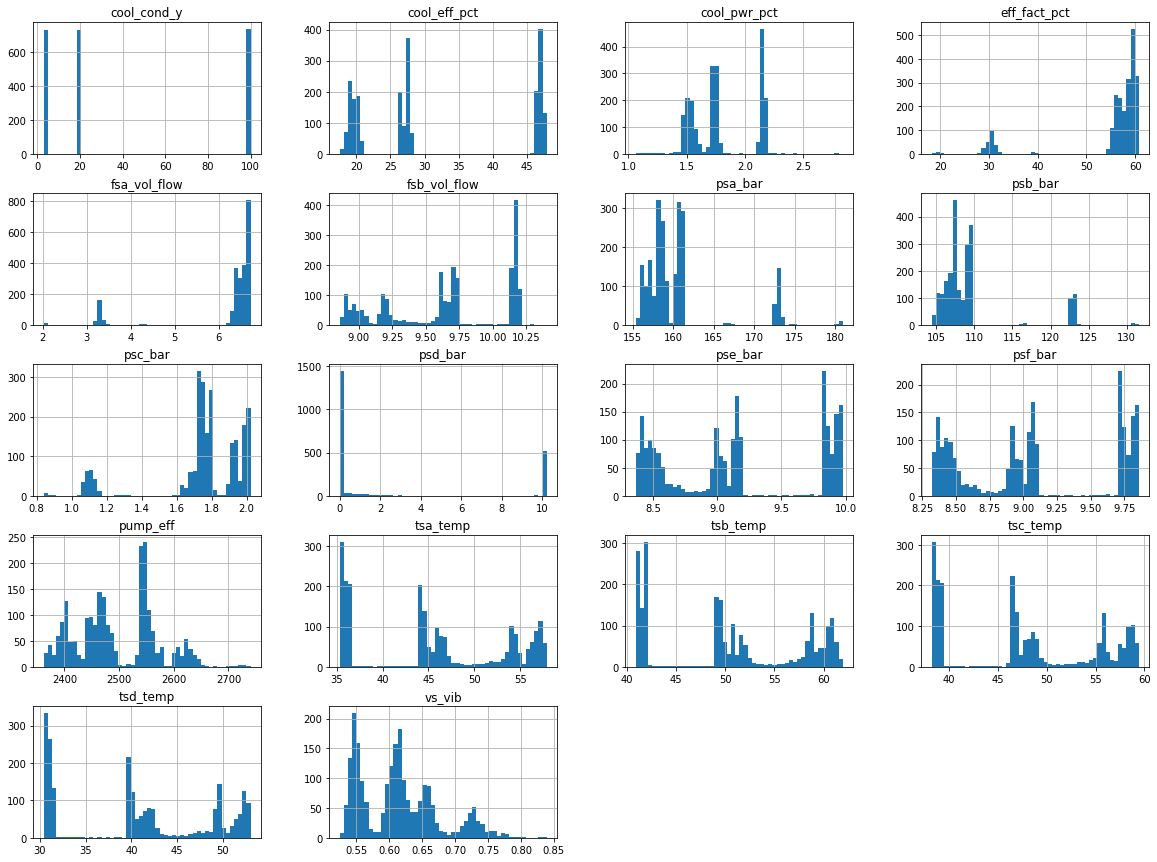

In [18]:
X_coolerCondition.hist(bins=50, figsize=(20,15))

Draw **Histogram** for X_valveCondition data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118bec978>,
      dtype=object)

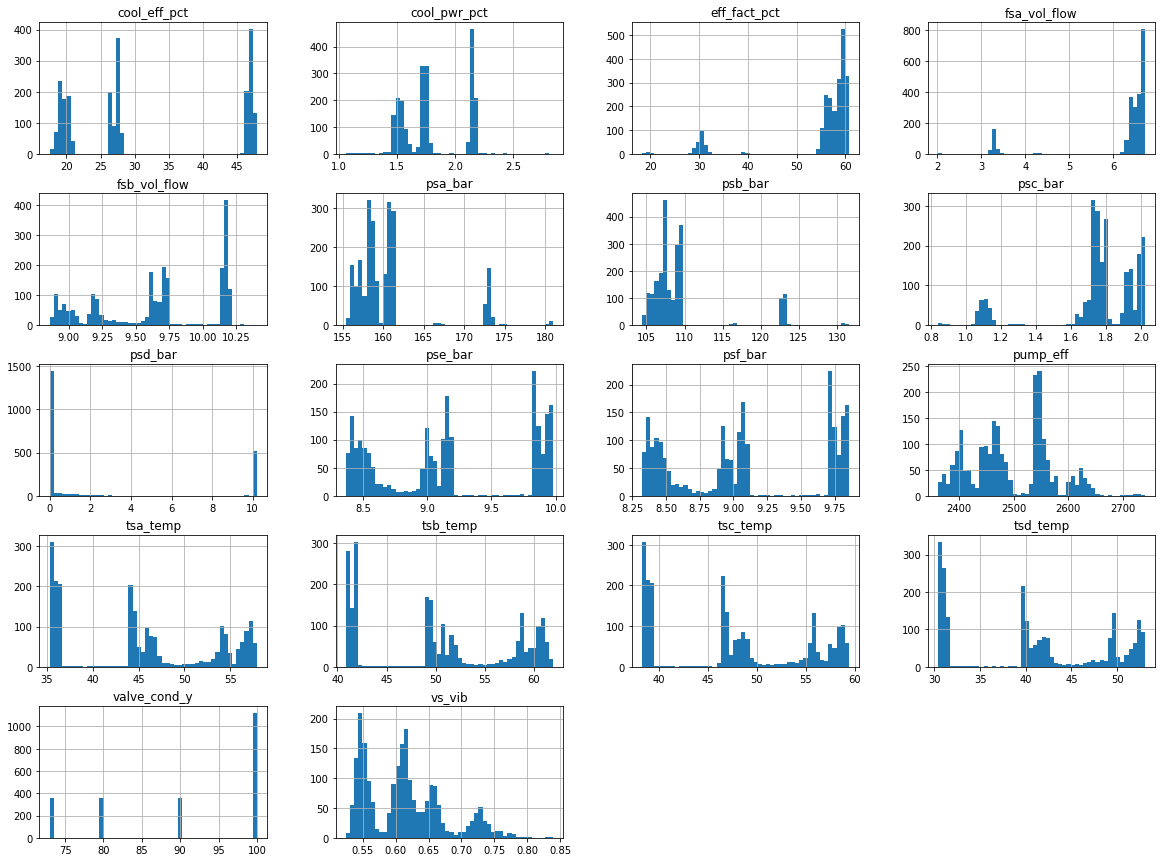

In [19]:
X_valveCondition.hist(bins=50, figsize=(20,15))

Draw **Histogram** for X_pumpLeak data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c8e1390>,
      dtype=object)

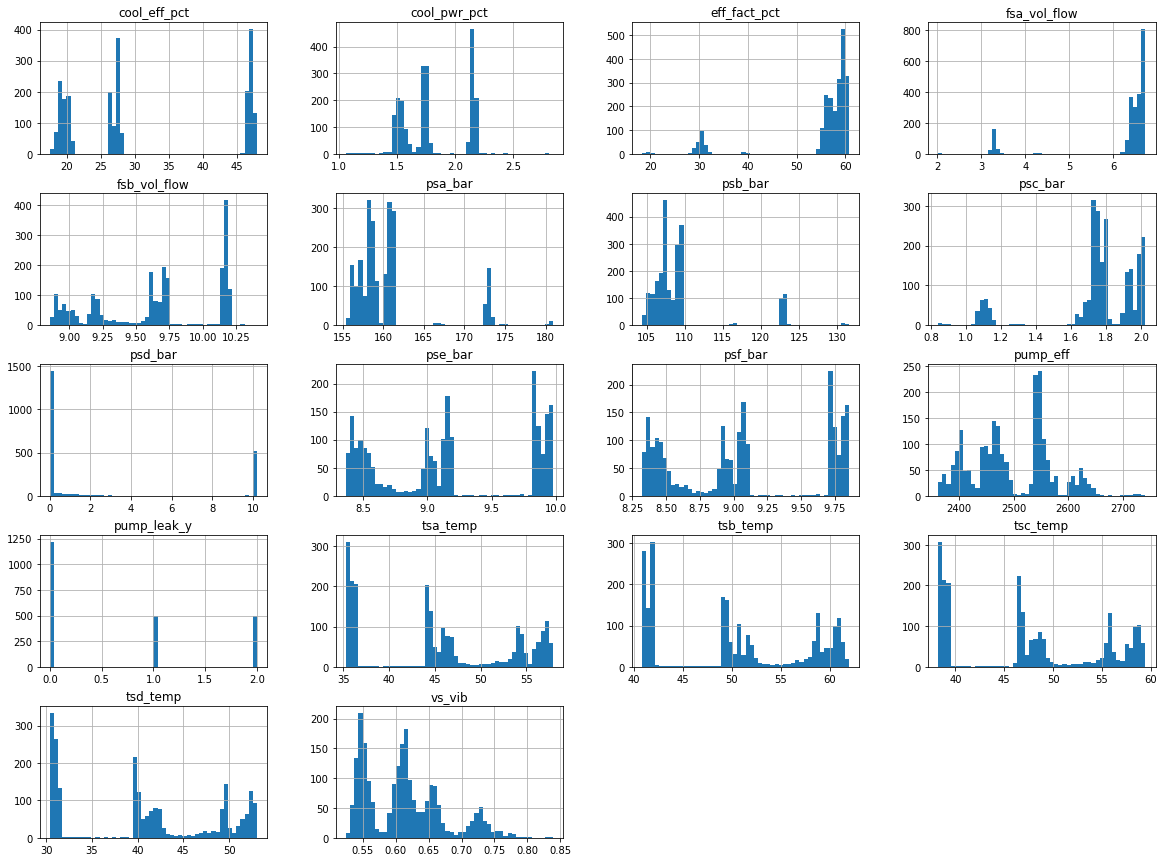

In [20]:
X_pumpLeak.hist(bins=50, figsize=(20,15))

Draw **Histogram** for X_hydraulicAcc data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14bfe9d30>,
      dtype=object)

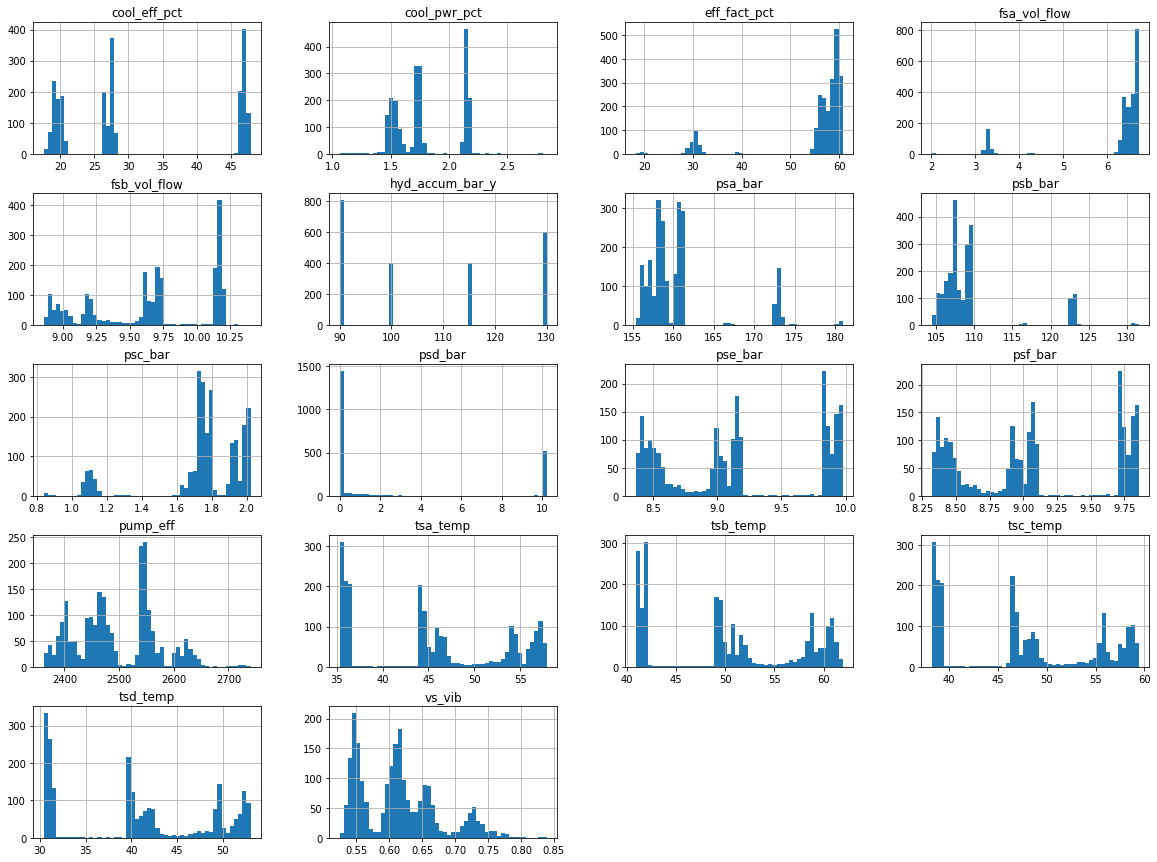

In [22]:
X_hydraulicAcc.hist(bins=50, figsize=(20,15))

Draw **Histogram** for X_stable data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14d52f588>,
      dtype=object)

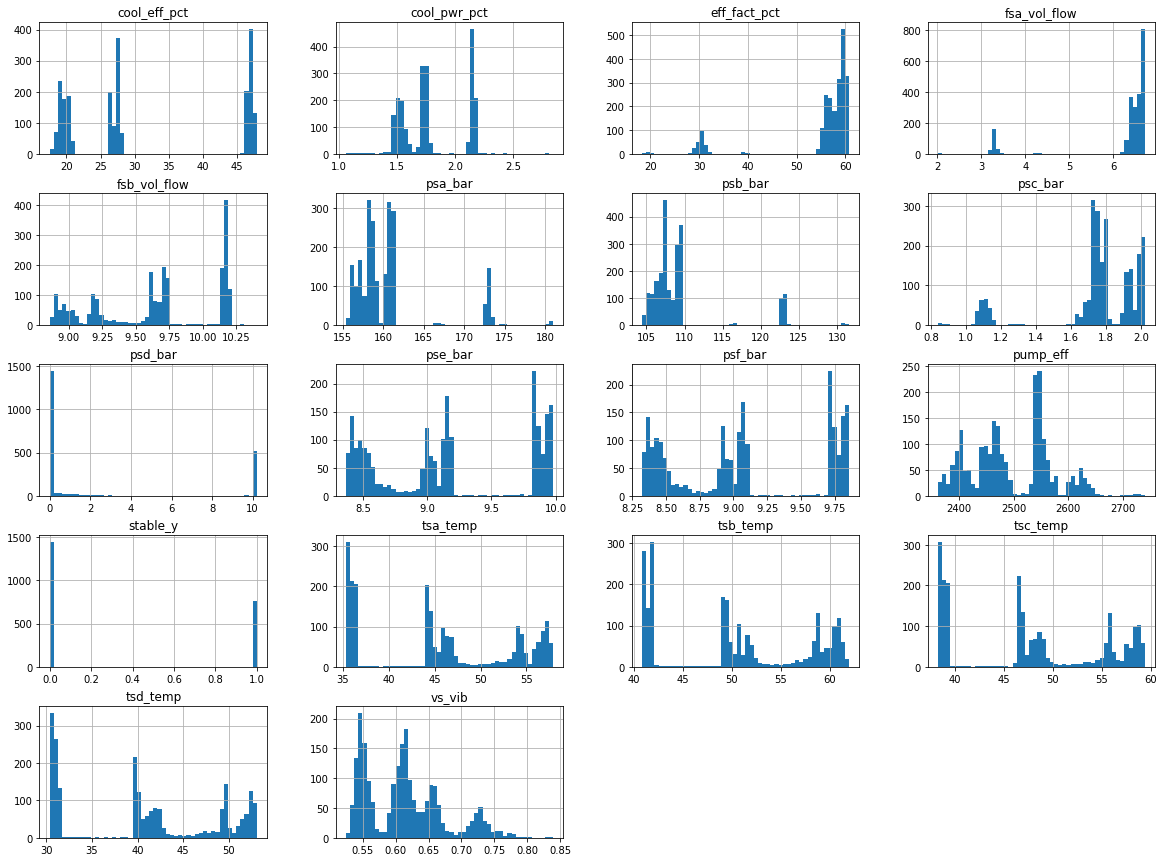

In [23]:
X_stable.hist(bins=50, figsize=(20,15))